---
## PEA model simulation (based on single trial learning model from Zhang et al 2024)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import integrate
from scipy.stats import norm
from scipy.special import logsumexp
from statsmodels.nonparametric.smoothers_lowess import lowess

%config InlineBackend.figure_format = "retina"

In [2]:
def pea(x_v, sigma_v, sigma_int, T, B):
    w_int = (1 / sigma_int**2) / (1 / sigma_int**2 + 1 / sigma_v**2)
    w_v = (1 / sigma_v**2) / (1 / sigma_int**2 + 1 / sigma_v**2)
    xhat_hand = w_v * x_v
    x_stl = B * (T - xhat_hand)
    return x_stl

def state_totalerr(previous_state, vis_err, T, B, A=0):
    state_est = A * previous_state + B * (T - vis_err)
    return state_est
    
def state_ege(previous_state, ege, T, B, A=0):
    state_est = A * previous_state + B * (T - ege)
    return state_est
 

In [3]:
use_tgt_file = False
if use_tgt_file == True:
    # Read in target file used for E1
    df_tgt = pd.read_csv("../inputs/target-files/ige_ege_jump1.csv")
    df_tgt = df_tgt.loc[69:, :].reset_index(drop=True)  # truncate, start w last bsl
    df_tgt["tgt_jump"] = df_tgt["tgt_angle_2"] - df_tgt["tgt_angle_1"]
    # df_tgt = df_tgt.loc[df_tgt["tgt_jump"] == 0, :].reset_index(drop=True)

    delta_x = df_tgt["rotation"]
    vis_fb = df_tgt["online_fb"]
    df_tgt.head()

In [4]:
# Simulated parameters
pert_size = np.array([-4, -2, 0, 2, 4])
n_per_pert = 100
n_per_miniblock = 2
num_trials = len(pert_size) * n_per_pert * n_per_miniblock + 1  # add 1 to get even number of adaptation measures
perts = np.repeat(pert_size, n_per_pert)
perts = np.random.permutation(perts)
pert_idx = np.arange(1, num_trials, n_per_miniblock)
prepert_idx = pert_idx - 1
postpert_idx = pert_idx + 1

delta_x = np.zeros(num_trials)
delta_x[pert_idx] = perts

# Test different fb schedules; names wrt which trials have vis fb
vis_fb_scheds = ["all", "pre pert", "post pert", "none", "mixed"]
vis_fb_sched = "none"
vis_fb = np.zeros(num_trials, dtype=bool)
if vis_fb_sched == "all":
    vis_fb = np.ones(num_trials, dtype=bool)
elif vis_fb_sched == "post pert":
    idx = np.sort(np.concatenate((pert_idx, postpert_idx)))
    vis_fb[idx] = 1
elif vis_fb_sched == "none":
    vis_fb[pert_idx] = 1
elif vis_fb_sched == "mixed":
    vis_fb = np.ones(num_trials, dtype="bool")
    idx = np.sort(np.random.choice(prepert_idx, size=int(len(prepert_idx) / 2), replace=False))
    vis_fb[idx] = 0
elif vis_fb_sched == "pre pert":
    idx = np.sort(np.concatenate((pert_idx, prepert_idx)))
    vis_fb[idx] = 1
    
# Simulate using retention factor
use_memory = True

## Intuitions regarding relationship between visual fb and sensitivity of analysis

### For half null, half perturbation trials

#### Assuming alternating between null and perturbation trials and no retention of adaptation across trials:
- Having no visual feedback on all null trials results in high sensitivity for detecting adaptation to IGE
    - PEA model and total error learning model show adaptation to IGE (as expected)
    - EGE-only learning model shows no adaptation to IGE (as expected)
- Having visual feedback on all trials results in near-zero sensitivity for detecting adaptation to IGE (Bad!)
    - PEA model and total error learning model show no adaptation (a bit of reverse adaptation, in fact) to IGE
    - EGE-only learning model shows no adaptaiton to IGE
- Having no visual feedback on a random mix of trials results in lower sensitivity for detecting adaptation to IGE

#### Evidence against retention across trials:
- With mixed schedule (visual fb on half of null trials, similar to actual protocol), for ege-only learner, there tends to be spurious relationship between IGE and adaptation (this is evidence against there being significant retention, because if there was, we would've seen this spurious correlation between adaptation and IGE in the real data!)
- Also, with A=0.84 (i.e., a reasonable value), you will see an unrealistically wide spread of IGE
- Using A=0.55 tends to keep motor variability within reasonable range BUT it is also more likely to create spurious correlations between adaptation and IGE (which, again, we did not see). 

#### Take-aways:
- There is most likely little role of retention factor in this experiment
- That being the case, no visual feedback on null trials will maximize sensitivity for detecting adaptation to IGE, should it exist


In [5]:
sigma_motor = 1.8
sigma_int = 7.364
eps = np.random.normal(loc=0, scale=sigma_motor, size=num_trials)  # motor noise
x_stl = np.zeros(num_trials)  # PEA observer
x_hand_pea = np.zeros(num_trials)
x_totalerr = np.zeros(num_trials)  # hand angle of state estimator, learns from total error
x_ege = np.zeros(num_trials)  # hand angle of state estimator, learns from ege only
x_ege_mem = np.zeros(num_trials)  # state estimator with non-zero retention factor
T = 0
if use_memory == True:
    A = 0.7  # 0.84 comes from Marko et al
else:
    A = 0.0
B = 0.5

# Loop through trials
for i in range(num_trials - 1):
    if i == 0:
        x_hand_pea[i] = eps[i]
        x_totalerr[i] = eps[i]
        x_ege[i] = eps[i]
    
    if vis_fb[i] == 0:
        x_v = 0
        sigma_v = 1e2
        vis_err = 0
        ege = 0
    else:
        x_v = x_hand_pea[i] + delta_x[i]
        sigma_v = 1.179 + 0.384 * np.abs(x_v)  # after Zhang et al
        vis_err = x_totalerr[i] + delta_x[i]
        ege = delta_x[i] 
    
    x_hand_pea[i + 1] = pea(x_v, sigma_v, sigma_int, T, B) + eps[i + 1]
    x_totalerr[i + 1] = state_totalerr(x_totalerr[i], vis_err, T, B, A) + eps[i + 1]
    x_ege[i + 1] = state_ege(x_ege[i], ege, T, B) + eps[i + 1]
    x_ege_mem[i + 1] = state_ege(x_ege_mem[i], ege, T, B, A) + eps[i + 1]
 

In [6]:
# Adaptation quantified as difference in hand angle post- and pre-perturbation
adapt_pea = np.zeros(num_trials)
adapt_pea[1::n_per_miniblock] = x_hand_pea[2::n_per_miniblock] - x_hand_pea[0:-1:n_per_miniblock]

adapt_ige = np.zeros(num_trials)
adapt_ige[1::n_per_miniblock] = x_totalerr[2::n_per_miniblock] - x_totalerr[0:-1:n_per_miniblock]

adapt_ege = np.zeros(num_trials)
adapt_ege[1::n_per_miniblock] = x_ege[2::n_per_miniblock] - x_ege[0:-1:n_per_miniblock]

adapt_ege_mem = np.zeros(num_trials)
adapt_ege_mem[1::n_per_miniblock] = x_ege_mem[2::n_per_miniblock] - x_ege_mem[0:-1:n_per_miniblock]

# Create data frame with all trials
df_pea = pd.DataFrame({
    "x_hand_pea":x_hand_pea, "x_totalerr":x_totalerr, "x_ege":x_ege, "x_ege_mem":x_ege_mem, "x_stl":x_stl, 
    "delta_x":delta_x, "adapt_pea":adapt_pea, "adapt_ige":adapt_ige, "adapt_ege": adapt_ege, "adapt_ege_mem":adapt_ege_mem,
})
df_pea.sample(5)

,x_hand_pea,x_totalerr,x_ege,x_ege_mem,x_stl,delta_x,adapt_pea,adapt_ige,adapt_ege,adapt_ege_mem
546,0.949520,2.622513,2.077946,3.607440,0.0,0.0,0.000000,0.000000,0.000000,0.000000
610,1.142855,-1.072412,-0.327621,-2.247298,0.0,0.0,0.000000,0.000000,0.000000,0.000000
293,1.156804,-0.207834,1.156804,0.996631,0.0,0.0,2.575374,1.989181,2.566897,1.007726
133,2.387924,-1.702216,2.387924,-3.991156,0.0,2.0,2.322362,6.231431,5.295235,7.047980
688,2.308461,0.738914,1.650086,-0.615170,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [7]:
# Create trimmed data frame without null trials
pea = df_pea.iloc[1::n_per_miniblock].reset_index()
pea.head()

,index,x_hand_pea,x_totalerr,x_ege,x_ege_mem,x_stl,delta_x,adapt_pea,adapt_ige,adapt_ege,adapt_ege_mem
0,1,-1.457118,-1.572508,-1.457118,-1.457118,0.0,-4.0,5.286169,4.693558,5.008060,3.823234
1,3,0.343511,3.513612,0.343511,3.019775,0.0,-2.0,-3.243715,-1.729188,-2.746412,0.387413
2,5,-1.957101,0.002568,-1.957101,0.990352,0.0,-2.0,-1.267519,-2.933236,-2.231027,-3.651623
3,7,-0.597336,-0.690932,-0.597336,-0.206019,0.0,4.0,-4.146485,-4.013547,-3.874847,-4.712306
4,9,2.094466,-0.808613,2.094466,-0.812832,0.0,2.0,1.141029,2.386642,2.410178,1.985409


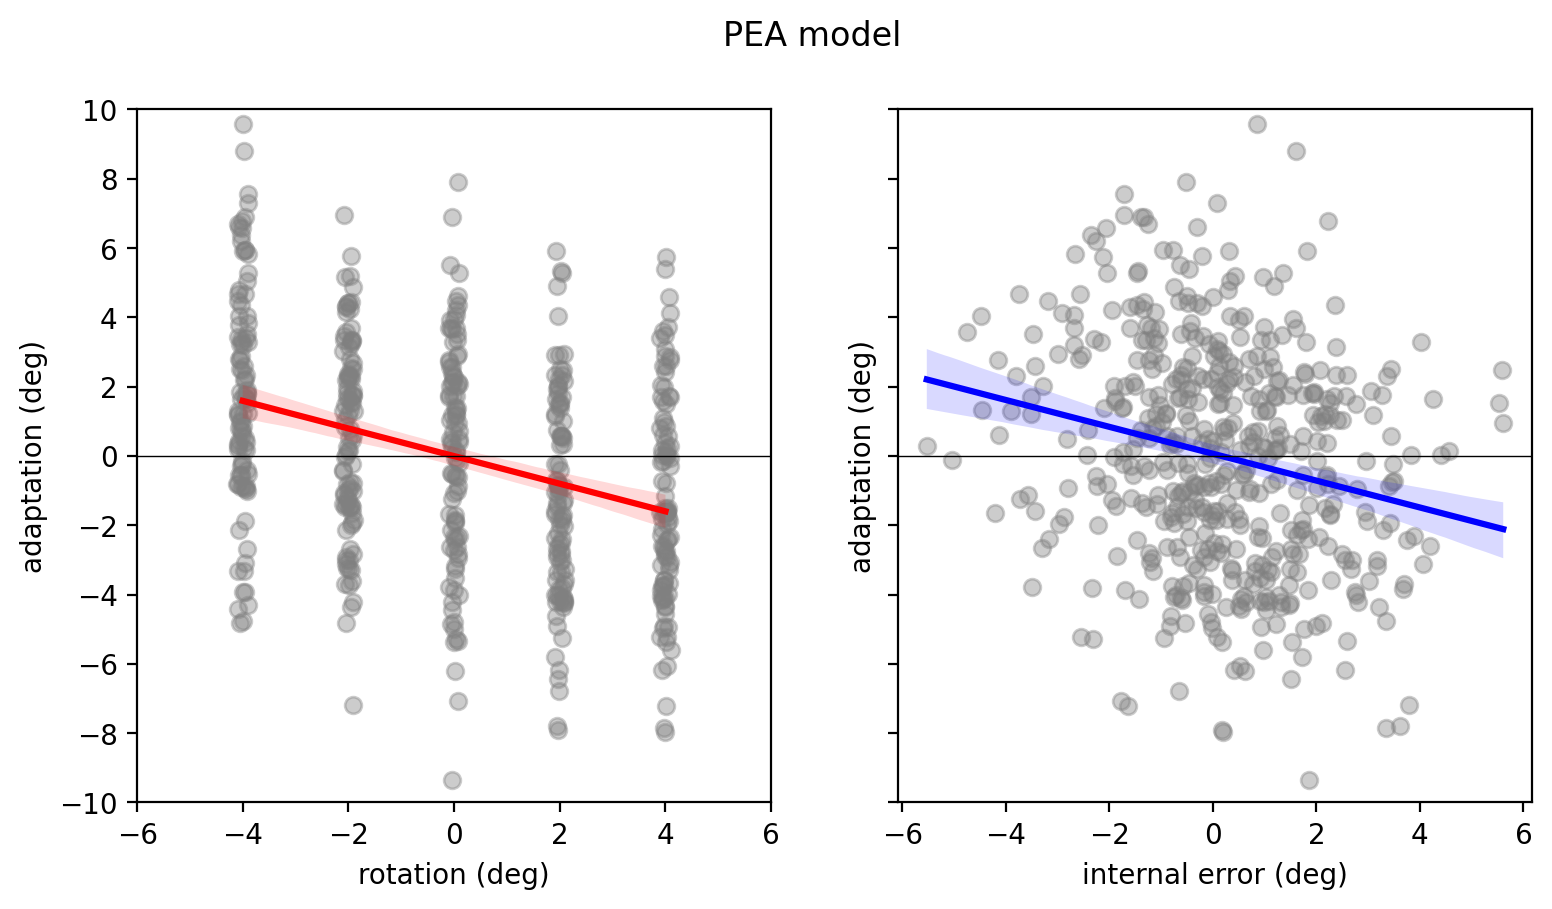

In [8]:
# PEA model
# Plot adaptation to external errors (lowess=True for 'piecewise' fit)
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(9, 4.5))
sns.regplot(data=pea, x="delta_x", x_jitter=0.1, y="adapt_pea", 
               scatter_kws={"alpha":0.4, "color":"gray"}, line_kws={"color":"r"}, ax=axs[0])
axs[0].set(xlabel="rotation (deg)", ylabel="adaptation (deg)", xlim=[-5, 5], xticks=np.arange(-6, 6.01, 2), 
           ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2))
axs[0].axhline(color="k", linewidth=0.5)

sns.regplot(data=pea, x="x_hand_pea", y="adapt_pea", line_kws={"color":"b"}, scatter_kws={"alpha":0.4, "color":"gray"}, ax=axs[1])
axs[1].set(ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2),
          xlabel="internal error (deg)", ylabel="adaptation (deg)")
axs[1].axhline(color="k", linewidth=0.5)

fig.suptitle("PEA model")
# fig.savefig("pea-model-sim.png")

plt.show()

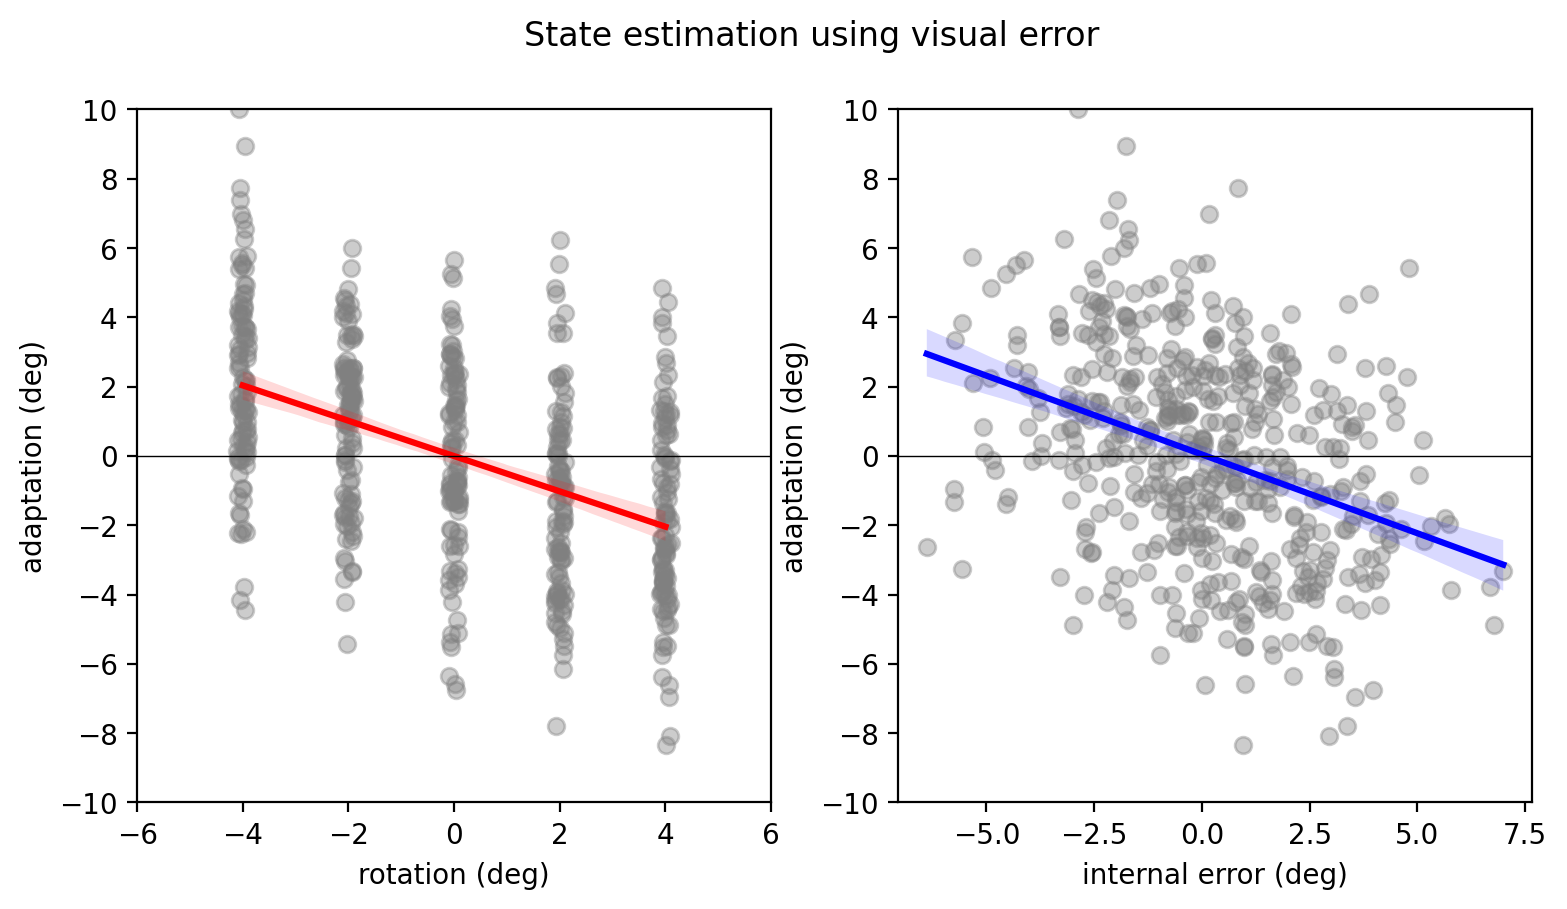

In [9]:
# State estimator (visual learner)
fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))
sns.regplot(data=pea, x="delta_x", x_jitter=0.1, y="adapt_ige", 
               scatter_kws={"alpha":0.4, "color":"gray"},  line_kws={"color":"r"}, ax=axs[0])
axs[0].set(xlabel="rotation (deg)", ylabel="adaptation (deg)", xlim=[-5, 5], xticks=np.arange(-6, 6.01, 2), 
           ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2))
axs[0].axhline(color="k", linewidth=0.5)

sns.regplot(data=pea, x="x_totalerr", y="adapt_ige", line_kws={"color":"b"}, scatter_kws={"alpha":0.4, "color":"gray"}, ax=axs[1])
axs[1].set(ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2),
          xlabel="internal error (deg)", ylabel="adaptation (deg)")
axs[1].axhline(color="k", linewidth=0.5)

fig.suptitle("State estimation using visual error")
# fig.savefig("state-est-sim.png")
plt.show()

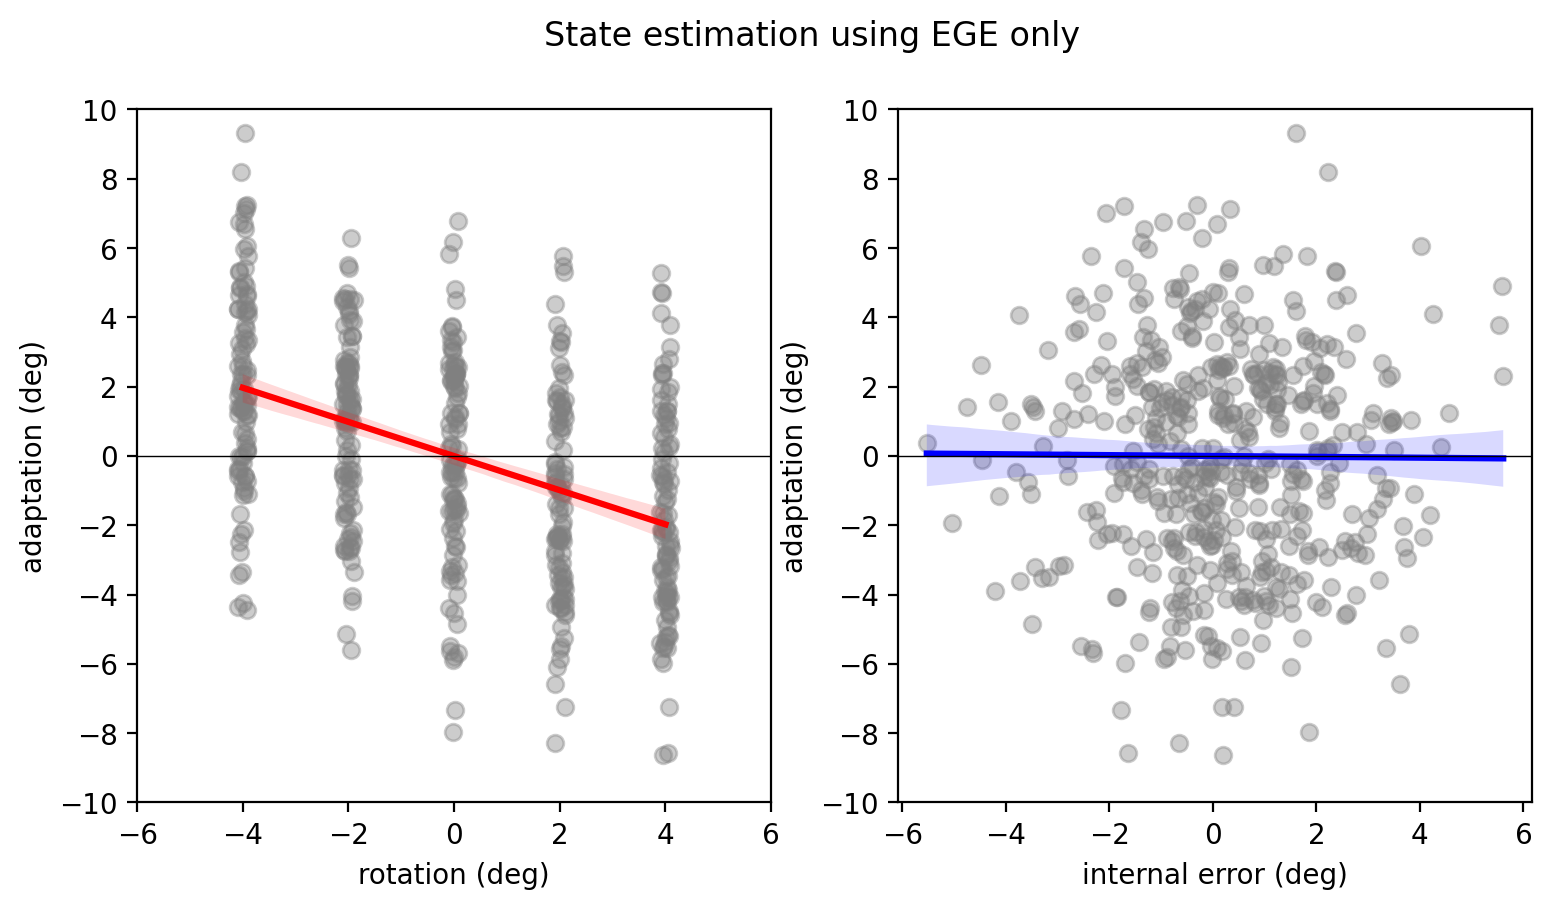

In [10]:
# State estimator (ege learner)
fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))
sns.regplot(data=pea, x="delta_x", x_jitter=0.1, y="adapt_ege", 
               scatter_kws={"alpha":0.4, "color":"gray"},  line_kws={"color":"r"}, ax=axs[0])
axs[0].set(xlabel="rotation (deg)", ylabel="adaptation (deg)", xlim=[-5, 5], xticks=np.arange(-6, 6.01, 2), 
           ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2))
axs[0].axhline(color="k", linewidth=0.5)

sns.regplot(data=pea, x="x_ege", y="adapt_ege", line_kws={"color":"b"}, scatter_kws={"alpha":0.4, "color":"gray"}, ax=axs[1])
axs[1].set(ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2),
          xlabel="internal error (deg)", ylabel="adaptation (deg)")
axs[1].axhline(color="k", linewidth=0.5)

fig.suptitle("State estimation using EGE only")
plt.show()

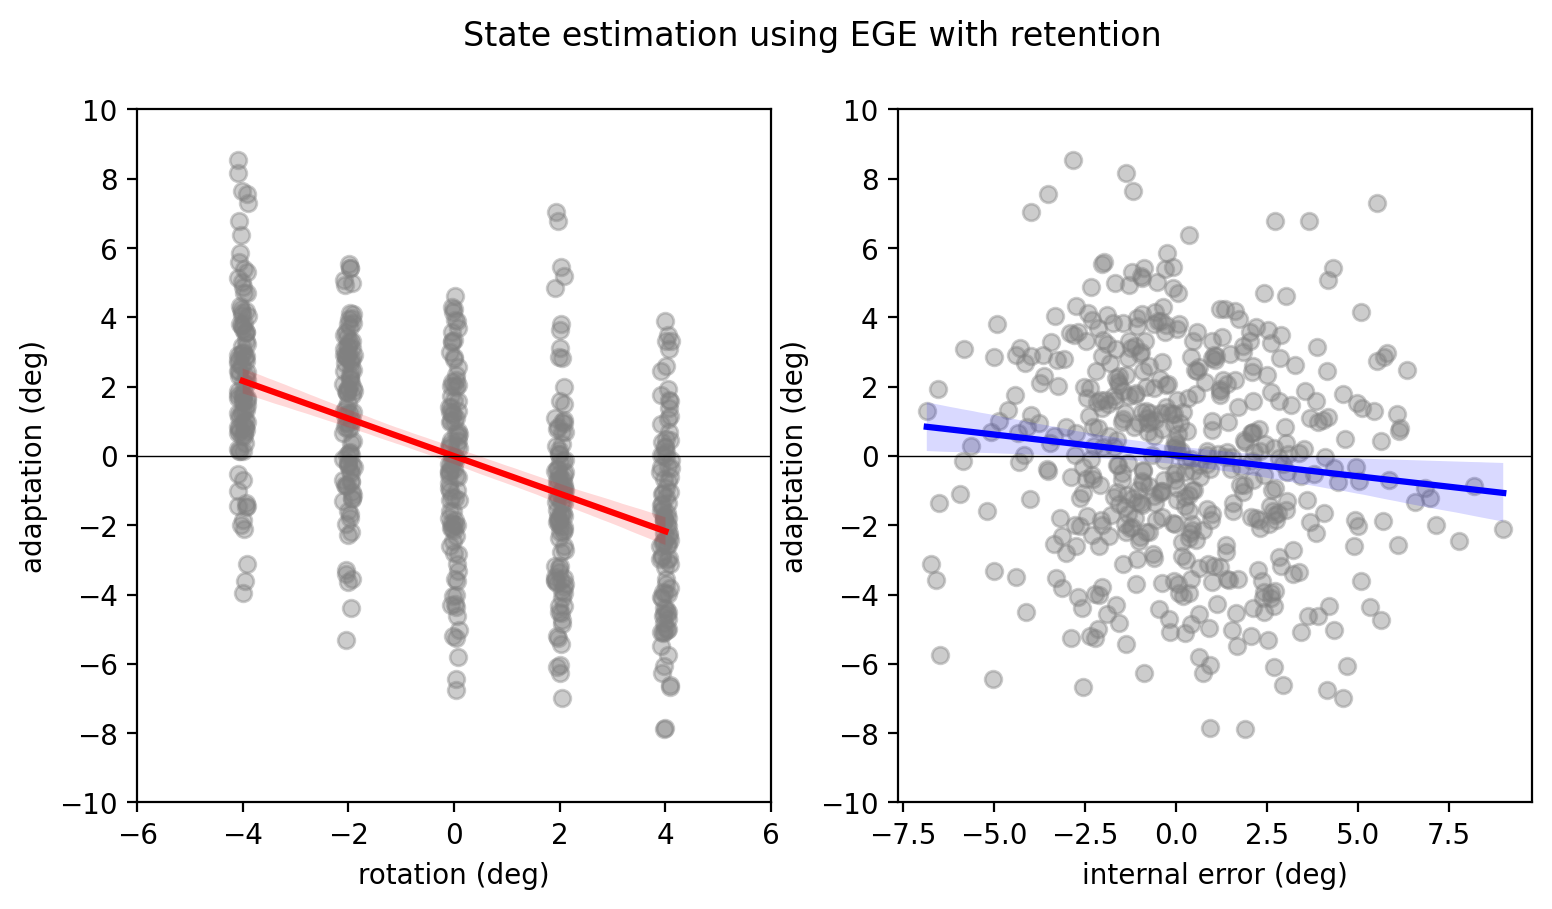

In [11]:
# State estimator with retention (ege learner)
fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))
sns.regplot(data=pea, x="delta_x", x_jitter=0.1, y="adapt_ege_mem", 
               scatter_kws={"alpha":0.4, "color":"gray"},  line_kws={"color":"r"}, ax=axs[0])
axs[0].set(xlabel="rotation (deg)", ylabel="adaptation (deg)", xlim=[-5, 5], xticks=np.arange(-6, 6.01, 2), 
           ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2))
axs[0].axhline(color="k", linewidth=0.5)

sns.regplot(data=pea, x="x_ege_mem", y="adapt_ege_mem", line_kws={"color":"b"}, scatter_kws={"alpha":0.4, "color":"gray"}, ax=axs[1])
axs[1].set(ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2),
          xlabel="internal error (deg)", ylabel="adaptation (deg)")
axs[1].axhline(color="k", linewidth=0.5)

fig.suptitle("State estimation using EGE with retention")
plt.show()

In [12]:
# Check motor variability
print("PEA |", "x_total |", "x_ege |", "x_ege_mem SD")
print(x_hand_pea.std().round(3), x_totalerr.std().round(3), x_ege.std().round(3), x_ege_mem.std().round(3))

PEA | x_total | x_ege | x_ege_mem SD
2.079 2.357 2.055 2.826


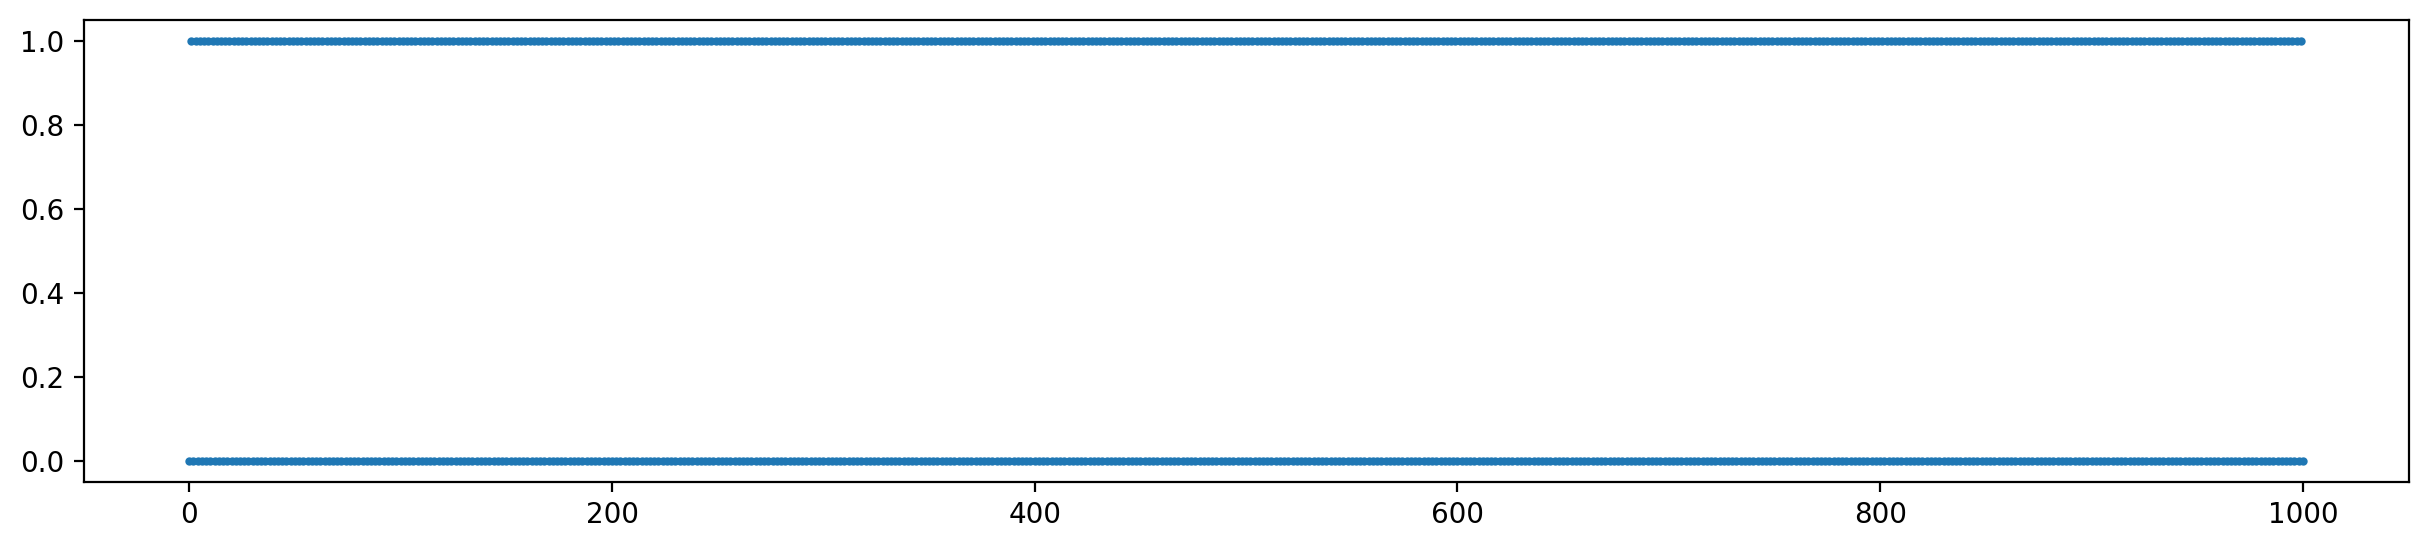

500
500


In [13]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.scatter(np.arange(num_trials), vis_fb, s=4)
plt.show()
print(vis_fb.sum())
print(vis_fb[pert_idx].sum())